&#x1f12f; Raquel Pérez & Javier Bejar - APA/GEI/FIB/UPC

In [1]:
# Descomentar para actualizar librerias
# Si se actualiza alguna libreria hay que reiniciar el notebook
!pip install pandas --upgrade  --quiet
!pip install numpy --upgrade  --quiet
!pip install scipy --upgrade  --quiet
!pip install statsmodels --upgrade  --quiet
!pip install scikit-learn --upgrade  --quiet
!pip install plotly --upgrade  --quiet
!pip install apafib --upgrade  --quiet

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from time import time
from datetime import timedelta
init_time = time()

# APA - Laboratorio - Sesión 2 

## Visualización/Reducción de dimensionalidad

Esta sesión trabajaremos diferentes métodos de visualización/reducción de dimensionalidad

El objetivo de este proceso es 

- Determinar si existen patrones en los datos mediante su inspección en un espacio de dimensionalidad reducida
- Determinar si hay redundancia de los datos
- Obtener un conjunto de datos con menos dimensiones que permita reducir el coste de ajustar un modelo (posiblemente perdiendo interpretabilidad) y/o hacer más evidentes los patrones para la tarea objetivo

Habitualmente realizaremos este paso después del preproceso de los datos principalmente porque los métodos de reducción de dimensionalidad pueden ser sensibles a los valores extremos y no aceptar valores perdidos

In [3]:
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()
import pandas as pd

from sklearn import set_config
import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# SECCIÓN 0: Visualizar es importante

El obtener la estadística básica de los datos no es suficiente para comprenderlos, muchos datos con características muy diferentes pueden tener los mismos valores, es famoso el cuarteto de Anscombe que muestra cuatro conjuntos diferentes que tienen la misma media y varianza, pero que no tienen nada que ver entre sí.

Se pueden construir conjuntos de datos que tienen la misma media y varianza que pueden corresponder a datos que tengan propiedades muy diferentes

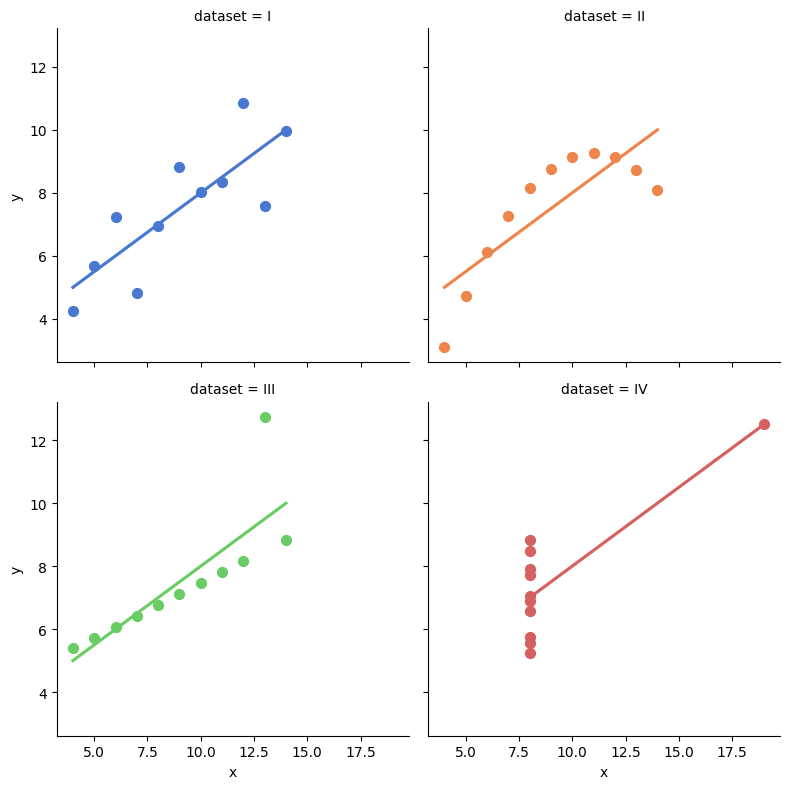

In [4]:
# Load the example dataset for Anscombe's quartet
df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(
    data=df, x="x", y="y", col="dataset", hue="dataset",
    col_wrap=2, palette="muted", ci=None,
    height=4, scatter_kws={"s": 50, "alpha": 1}
);

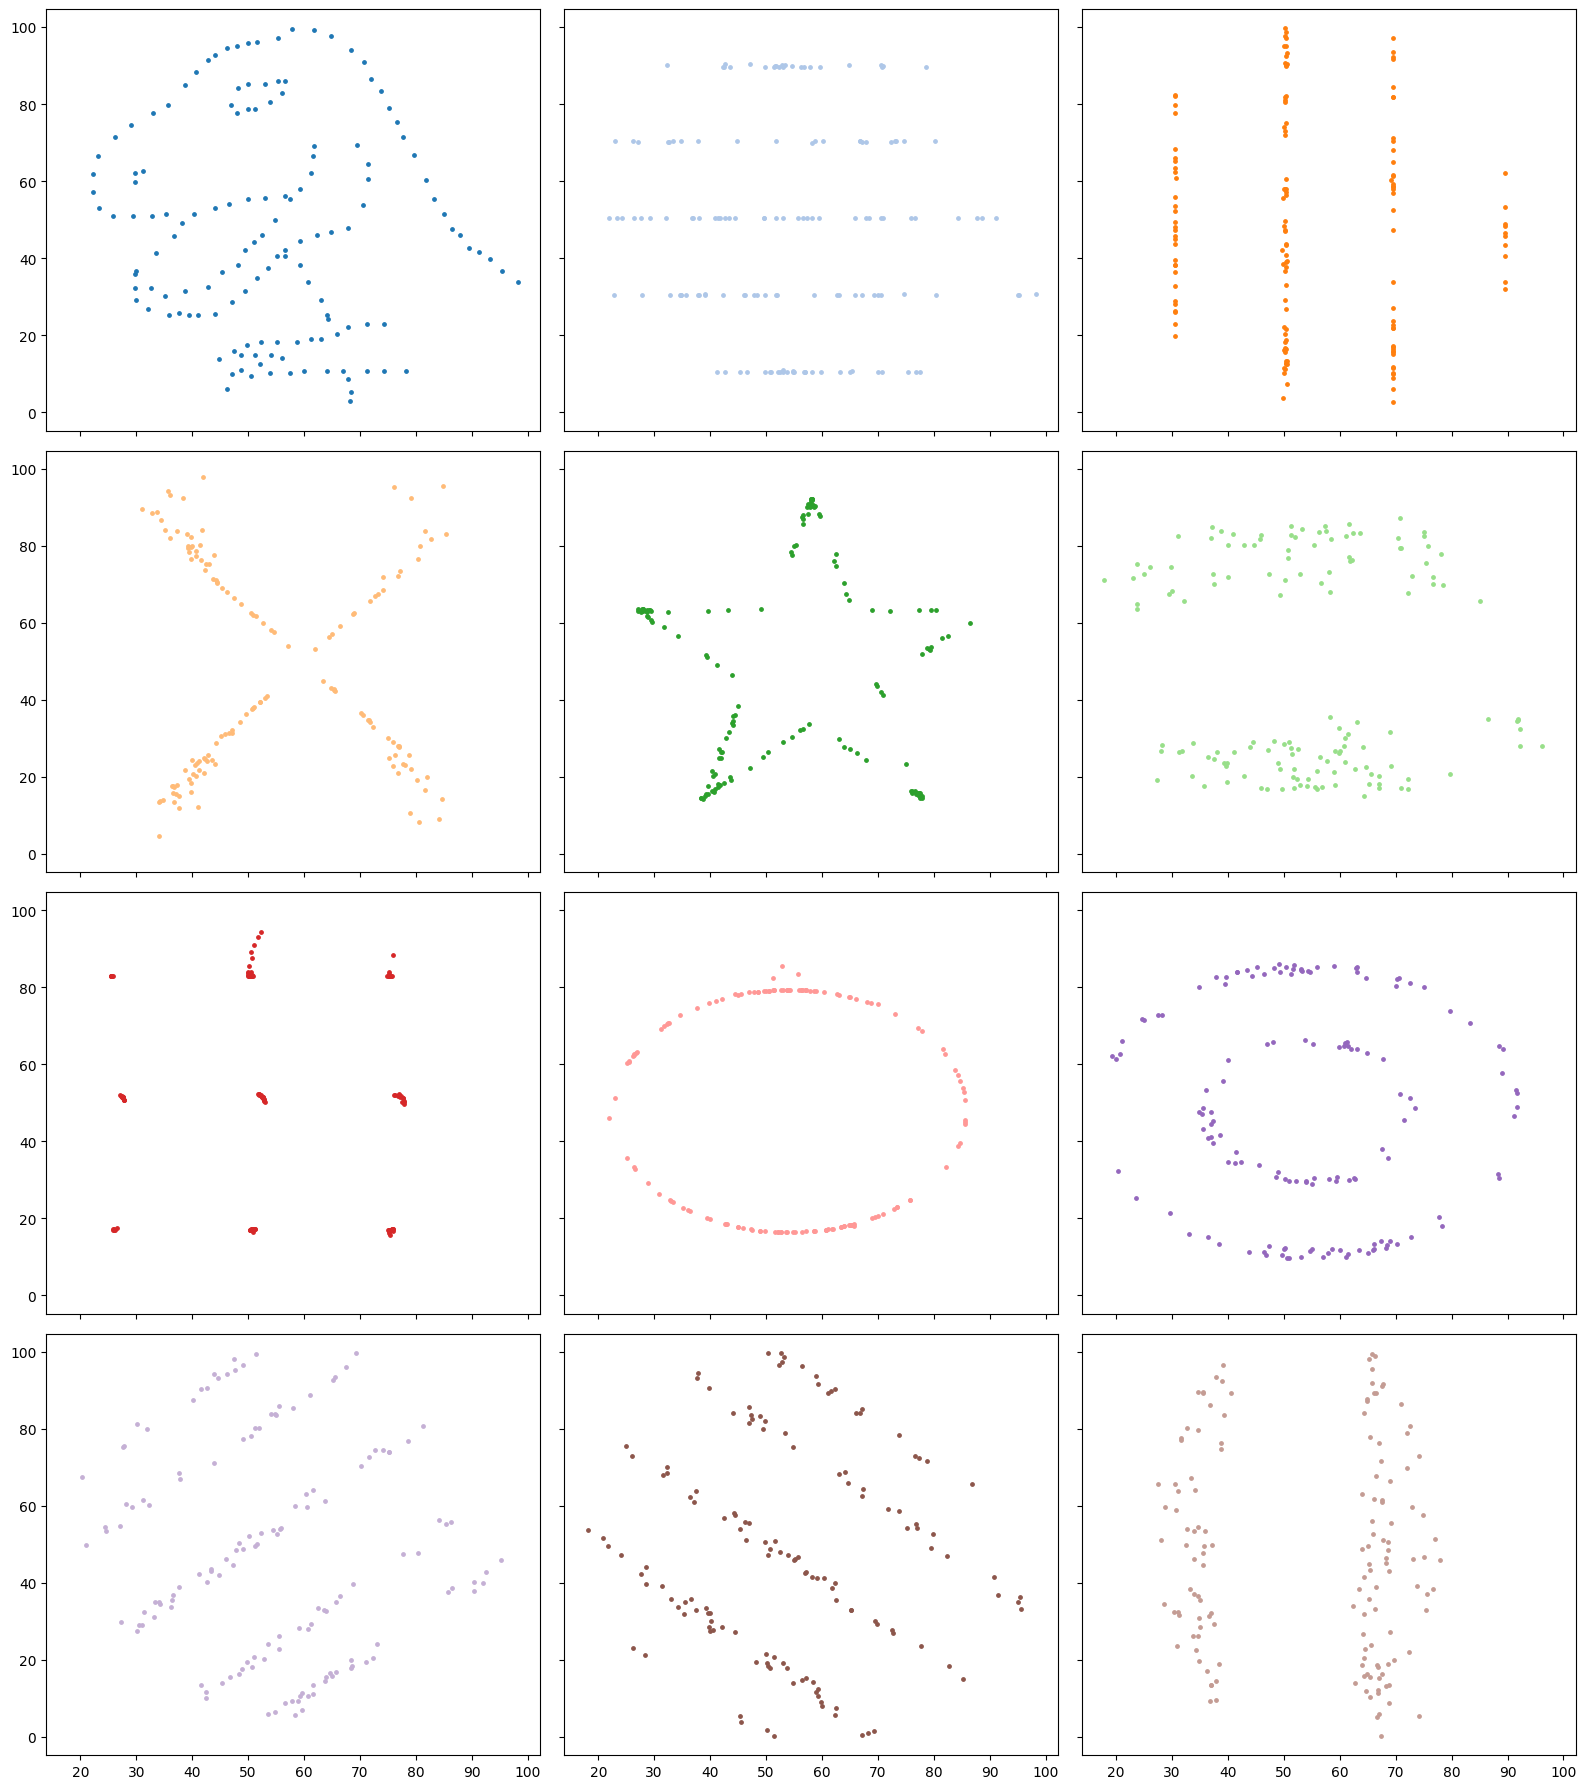

In [5]:
url = "https://raw.githubusercontent.com/probml/probml-data/main/data/DatasaurusDozen.tsv"
df = pd.read_csv(url, sep="\t")

dataset_names = ["dino","h_lines","v_lines","x_shape","star","high_lines","dots","circle",
    "bullseye","slant_up","slant_down","wide_lines"]

fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(16,18));

axs = []
for row in axes:
    for ax in row:
        axs.append(ax);
        
color_map = plt.cm.get_cmap('tab20');
df_stat = pd.DataFrame()

for i, ax, name in zip(range(len(axs)), axs, dataset_names):
    name_index = df["dataset"] == name
    data_df = df[name_index]
    data_df = data_df.sort_values(by="x")
    x = data_df["x"].values.reshape(-1, 1)
    y = data_df["y"].values.reshape(-1, 1)
    _ = ax.scatter(x, y, s=6, color=color_map(i)); 
    
    df_dataset = pd.DataFrame({f'{name}_x':data_df["x"].values,f'{name}_y':data_df["y"].values })
    df_stat = pd.concat([df_stat,df_dataset],axis=1)

plt.tight_layout()

In [6]:
df_stat.describe().loc[['count', 'mean', 'std']].T

,count,mean,std
dino_x,142.0,54.263,16.765
dino_y,142.0,47.832,26.935
h_lines_x,142.0,54.261,16.766
h_lines_y,142.0,47.830,26.940
v_lines_x,142.0,54.270,16.770
v_lines_y,142.0,47.837,26.938
x_shape_x,142.0,54.260,16.770
x_shape_y,142.0,47.840,26.930
star_x,142.0,54.267,16.769
star_y,142.0,47.840,26.930


## SECCIÓN 1: Visualizando el conjunto de datos crabs

Campbell estudió los cangrejos de roca del género "Leptograpsus" en 1974. Una especie, Leptograpsus variegatus, se había dividido en dos nuevas especies, previamente agrupadas por color (naranja y azul). Los especímenes preservados pierden su color, por lo que se esperaba que las diferencias morfológicas permitieran clasificar el material del museo.

Hay datos disponibles sobre 50 especímenes de cada sexo de cada especie (200 en total), recolectados en Fremantle, Australia Occidental. Cada espécimen tiene medidas sobre: ​​el ancho del lóbulo frontal (FL), el ancho trasero (RW), la longitud a lo largo de la línea media del caparazón (CL), el ancho máximo (CW) del caparazón y la profundidad del cuerpo (BD) en mm, además de color (es decir, la especie) y sexo.


In [7]:
try:
    from apafib import load_crabs
    crabs_data = load_crabs()
except:
    crabs_data = pd.read_csv("crabs.csv", header=0)

crabs_data = crabs_data.rename(columns={'sp':'species', 'FL':'Frontal Lobe', 'RW':'Rear Width', 
                            'CL':'Caparace Midline','CW':'Maximum width', 'BD':'Body Depth'})

crabs_data['species'] = crabs_data['species'].map({'B':'Blue', 'O':'Orange'})
crabs_data['sex'] = crabs_data['sex'].map({'M':'Male', 'F':'Female'})

crabs_data.describe(include='all')
crabs_data.head()

,species,sex,Frontal Lobe,Rear Width,Caparace Midline,Maximum width,Body Depth
count,200,200,200.000,200.000,200.000,200.000,200.000
unique,2,2,NaN,NaN,NaN,NaN,NaN
top,Blue,Male,NaN,NaN,NaN,NaN,NaN
freq,100,100,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,15.583,12.738,32.105,36.415,14.030
std,NaN,NaN,3.495,2.573,7.119,7.872,3.425
min,NaN,NaN,7.200,6.500,14.700,17.100,6.100
25%,NaN,NaN,12.900,11.000,27.275,31.500,11.400
50%,NaN,NaN,15.550,12.800,32.100,36.800,13.900
75%,NaN,NaN,18.050,14.300,37.225,42.000,16.600


,species,sex,Frontal Lobe,Rear Width,Caparace Midline,Maximum width,Body Depth
0,Blue,Male,8.1,6.7,16.1,19.0,7.0
1,Blue,Male,8.8,7.7,18.1,20.8,7.4
2,Blue,Male,9.2,7.8,19.0,22.4,7.7
3,Blue,Male,9.6,7.9,20.1,23.1,8.2
4,Blue,Male,9.8,8.0,20.3,23.0,8.2


El objetivo es separar los 200 cangrejos en cuatro clases, dadas por las configuraciones 2x2 para sexo (macho/hembra) y especie (azul/naranja)

In [8]:
crabs_data['class'] =  crabs_data.species + crabs_data.sex

crabs_data['class'].value_counts()

class
BlueMale        50
BlueFemale      50
OrangeMale      50
OrangeFemale    50
Name: count, dtype: int64

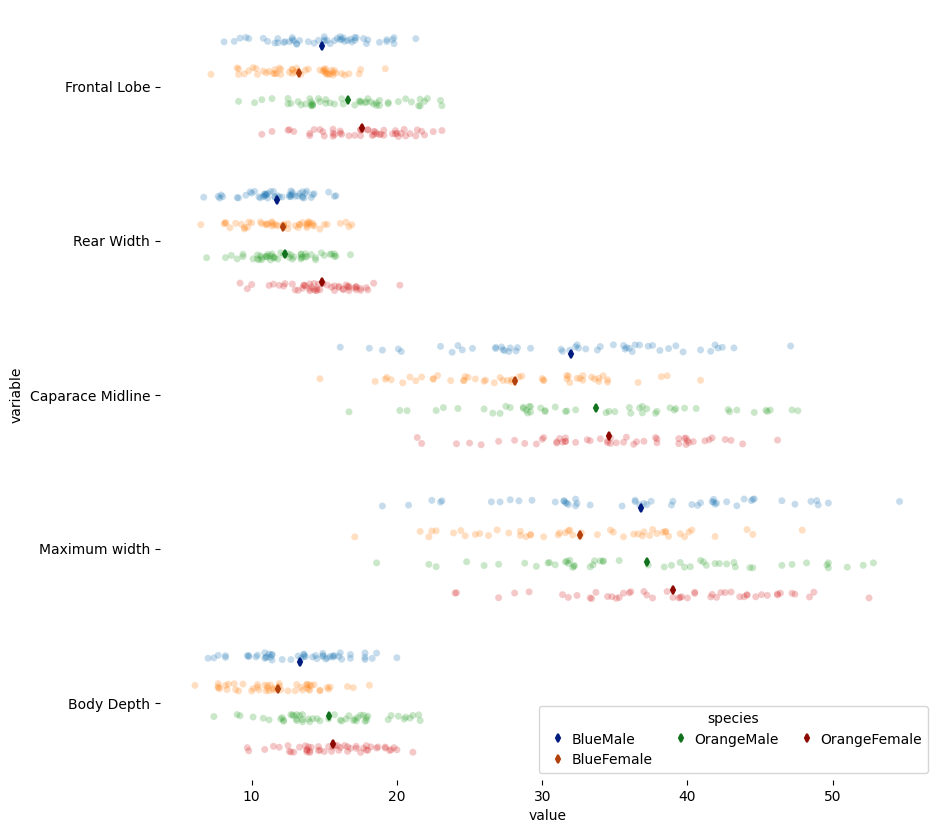

In [9]:
df = pd.melt(crabs_data, id_vars=['class'], value_vars=['Frontal Lobe', 'Rear Width', 
                      'Caparace Midline','Maximum width', 'Body Depth'])

f, ax = plt.subplots(figsize=(10,10));
sns.despine(bottom=True, left=True);
sns.stripplot(x="value", y="variable", hue="class", data=df, dodge=True, alpha=.25, zorder=1);
sns.pointplot(x="value", y="variable", hue="class", data=df, 
               dodge=.8 - .8 / 3, join=False, palette="dark",markers="d", scale=.75, ci=None);
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles[4:], labels[4:], title="species",
          handletextpad=0, columnspacing=1, loc="lower right", ncol=3, frameon=True);

Empezaremos con una exploración básica del conjunto de datos

In [10]:
data_columns = ['Frontal Lobe','Rear Width','Caparace Midline','Maximum width','Body Depth']
crabs_data[data_columns].describe()

,Frontal Lobe,Rear Width,Caparace Midline,Maximum width,Body Depth
count,200.000,200.000,200.000,200.000,200.000
mean,15.583,12.738,32.105,36.415,14.030
std,3.495,2.573,7.119,7.872,3.425
min,7.200,6.500,14.700,17.100,6.100
25%,12.900,11.000,27.275,31.500,11.400
50%,15.550,12.800,32.100,36.800,13.900
75%,18.050,14.300,37.225,42.000,16.600
max,23.100,20.200,47.600,54.600,21.600


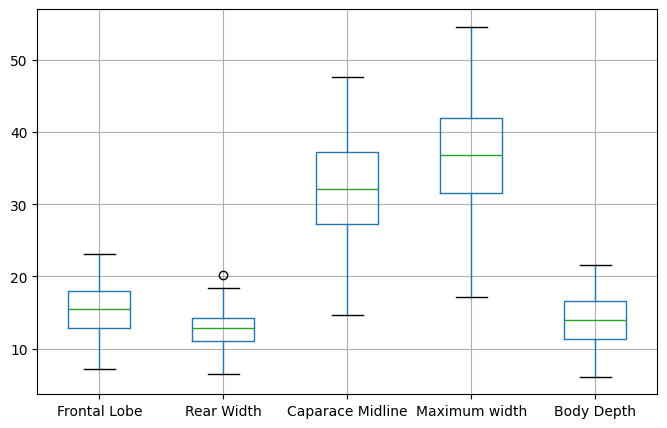

In [11]:
fig, ax = plt.subplots(figsize=(8,5));
crabs_data[data_columns].boxplot();

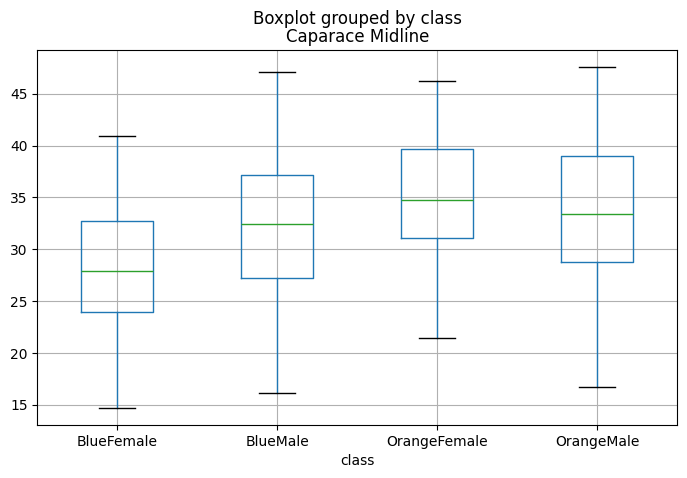

In [12]:
crabs_data.boxplot(column='Caparace Midline', by='class',figsize=(8,5));

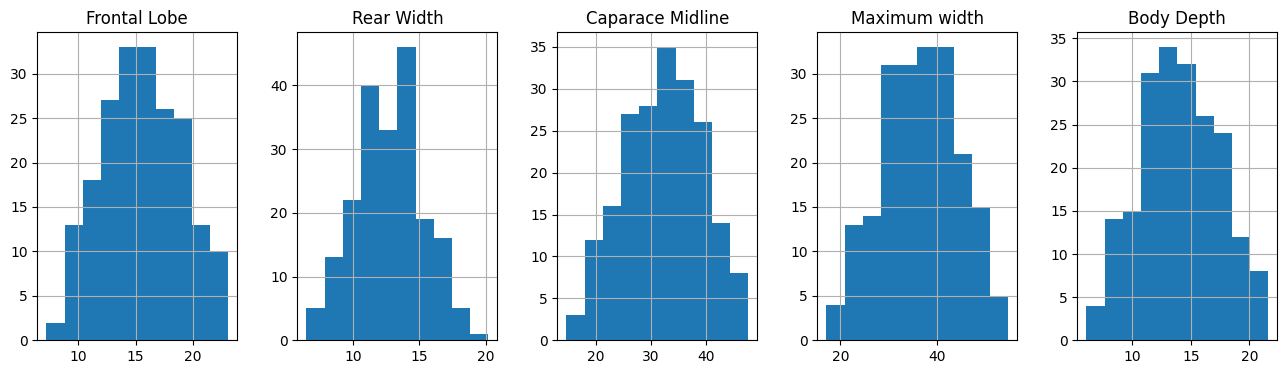

In [13]:
crabs_data[data_columns].hist(figsize=(16,4), layout=(1,5));

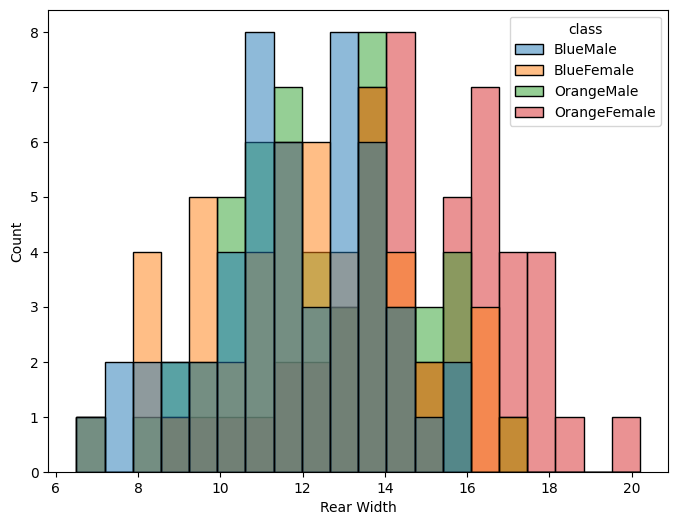

In [14]:
plt.figure(figsize=(8,6));
sns.histplot(crabs_data,x='Rear Width', hue='class',bins=20);

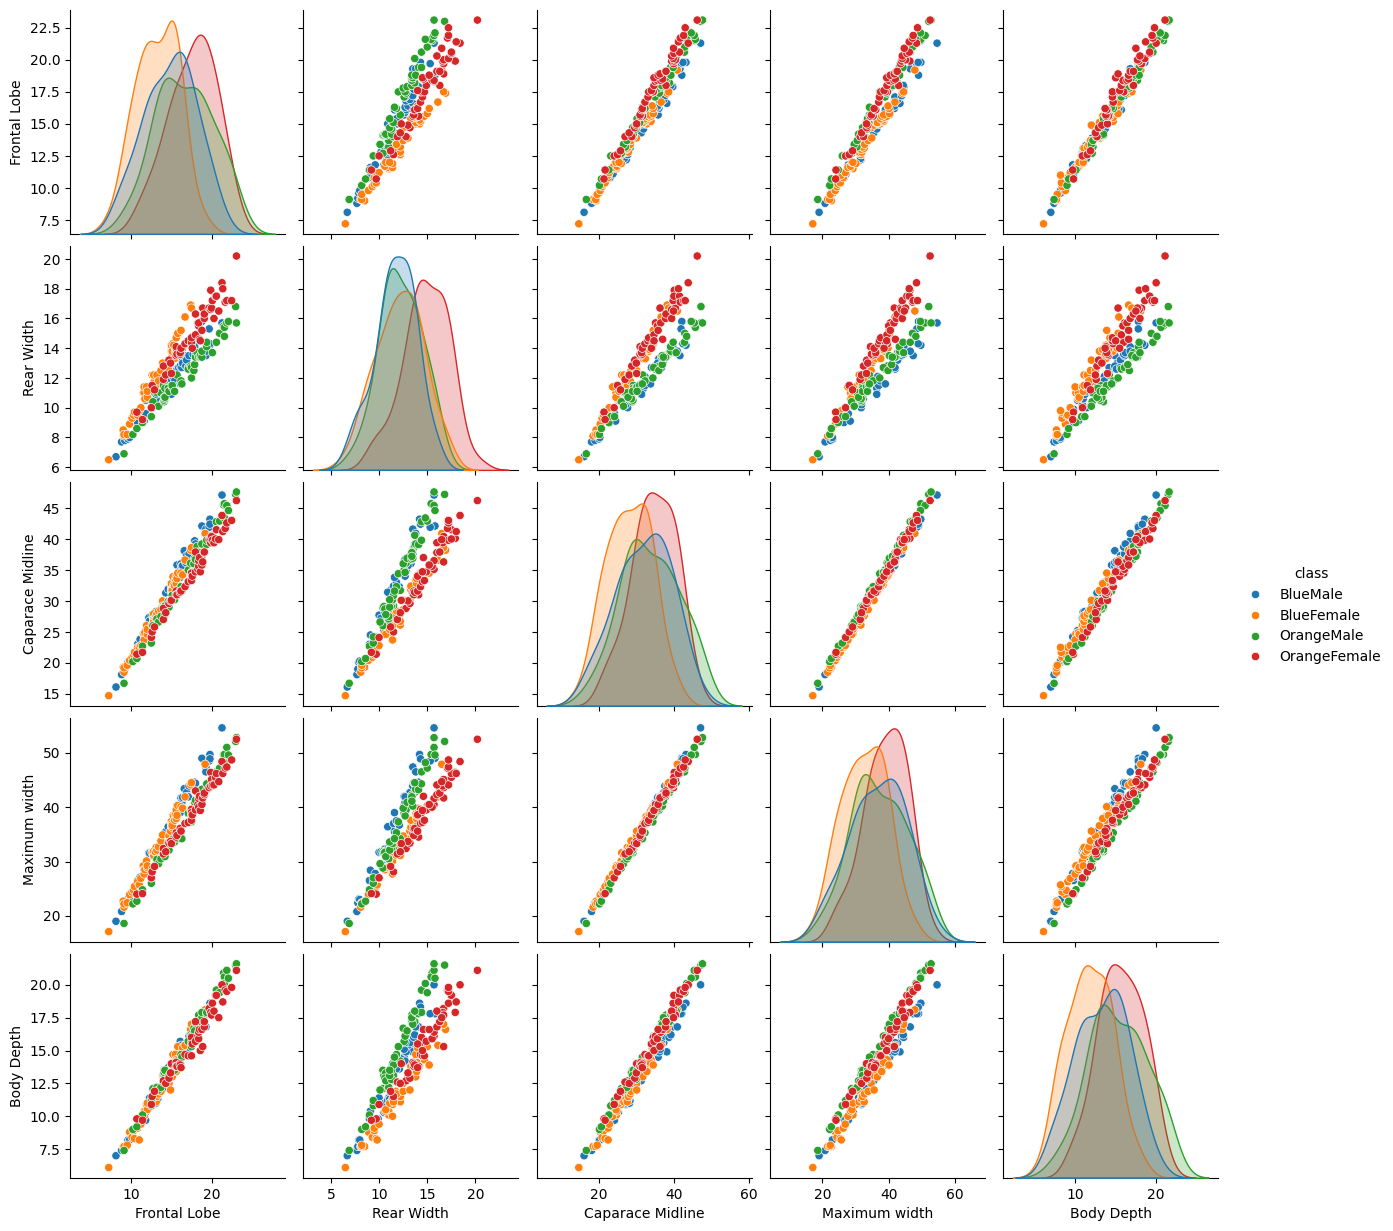

In [15]:
sns.pairplot(crabs_data, hue='class');

## SECCIÓN 2: PCA 

Ahora vamos a usar PCA para hacer una mejor visualización de nuestros datos.

PCA se basa en la matriz de covarianza de las variables, asume que los datos estan estandarizados, asi que aplicaremos esa transformación. Esto cambiará los datos para que todas las variables tengan media 0 y desviación estándar 1.

In [26]:
crabs_standarized = crabs_data.copy()
crabs_standarized[data_columns] = StandardScaler().fit_transform(crabs_data[data_columns])
crabs_standarized.describe().T

,count,mean,std,min,25%,50%,75%,max
Frontal Lobe,200.0,-7.105e-17,1.003,-2.404,-0.770,-9.465e-03,0.708,2.156
Rear Width,200.0,6.040e-16,1.003,-2.430,-0.677,2.396e-02,0.608,2.907
Caparace Midline,200.0,1.066e-16,1.003,-2.451,-0.680,-7.745e-04,0.721,2.182
Maximum width,200.0,-4.974e-16,1.003,-2.460,-0.626,4.909e-02,0.711,2.316
Body Depth,200.0,0.000e+00,1.003,-2.321,-0.770,-3.820e-02,0.752,2.216


El método PCA de scikit-learn devolverá la relación de varianza explicada y todos los parámetros importantes relacionados con PCA.

Se puede usar la relación de varianza explicada y los valores singulares para decidir cuántos componentes conservar.

In [18]:
myPCA = PCA().fit(crabs_standarized[data_columns]);

print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())

[9.57766957e-01 3.03370413e-02 9.32659482e-03 2.22707143e-03
 3.42335531e-04]
[0.95776696 0.988104   0.99743059 0.99965766 1.        ]


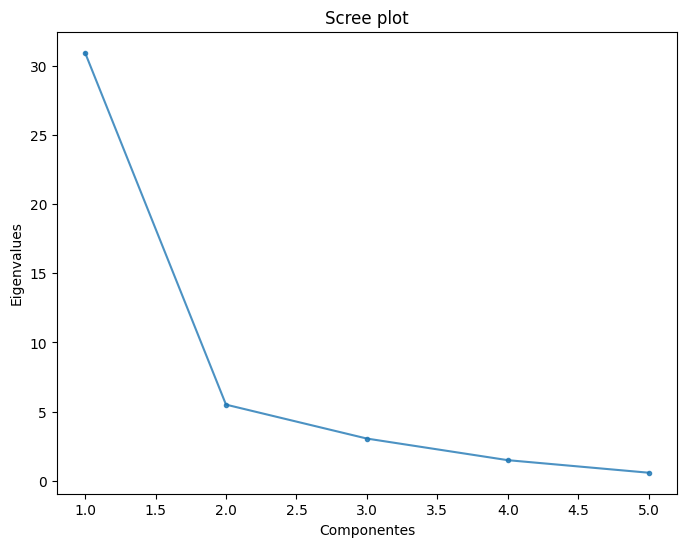

In [19]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.');
y_label = plt.ylabel('Eigenvalues');
x_label = plt.xlabel('Componentes');
plt.title('Scree plot');

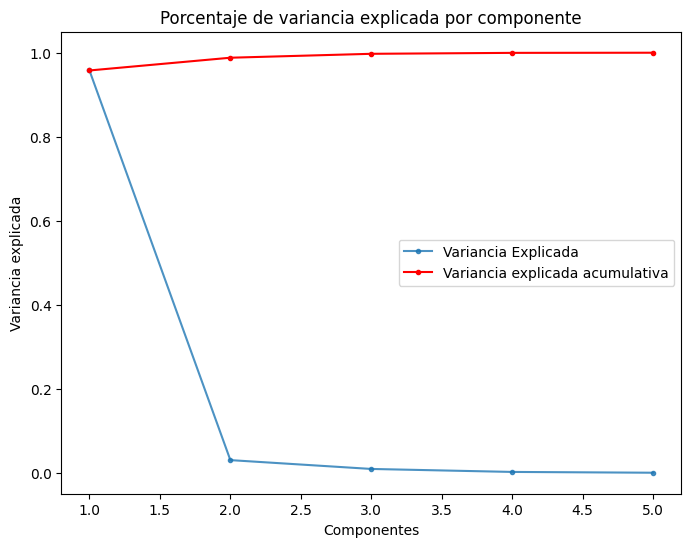

In [20]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Podemos visualizar también los pesos que le asigna el PCA a cada componente

En el caso de que la variancia que tiene un componente sea grande podemos ver en los pesos la contribucion de cada variable a esa varianza conjunta. En este caso el primer componente tiene casi toda la varianza explicada por la transformacion y todas las variables contribuyen practicamente igual. En el caso de haber diferencias, esto podría darnos una idea de la relevancia de los atributos.

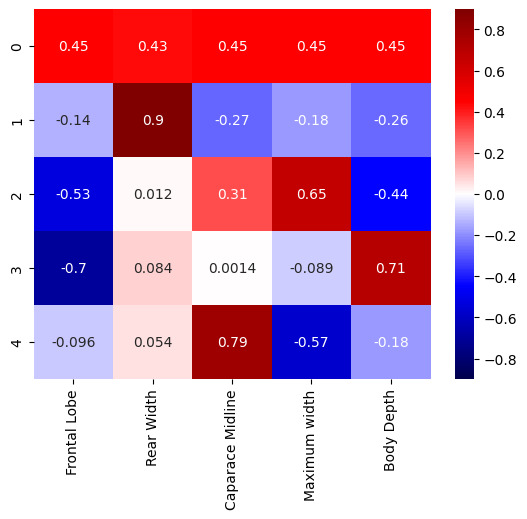

In [21]:
sns.heatmap(myPCA.components_, cmap='seismic', 
            xticklabels=list(crabs_data.columns[2:-1]),
            vmin=-np.max(np.abs(myPCA.components_)),
            vmax=np.max(np.abs(myPCA.components_)),
            annot=True);

Ahora podemos transformar nuestro conjunto de datos utilizando el PCA "entrenado".

Generalmente, para la visualización, se eligen 2 o 3 componentes.

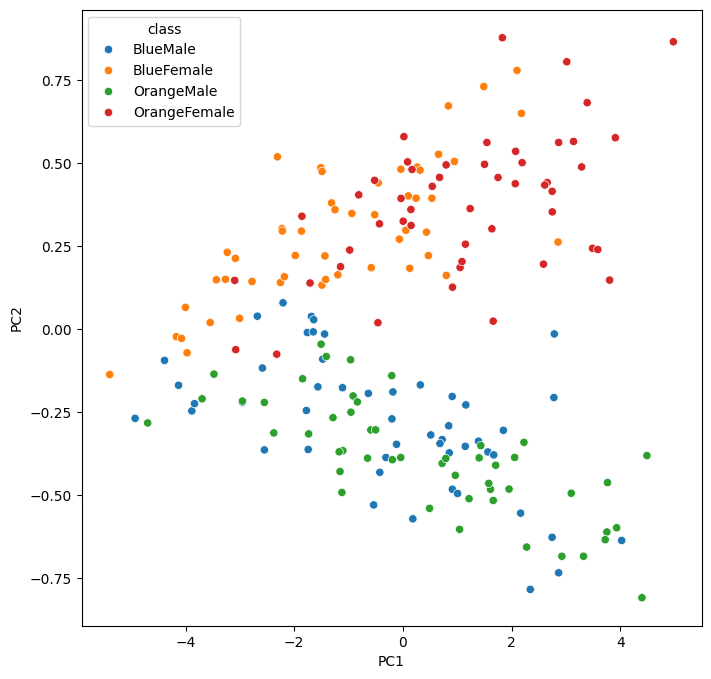

In [28]:
transformed_crabs = myPCA.transform(crabs_standarized[data_columns])
crabs_standarized[['PC1','PC2', 'PC3']] = transformed_crabs[:,:3]
fig = plt.figure(figsize=(8,8))
_ = sns.scatterplot(x='PC1', y='PC2', hue='class', data=crabs_standarized)

Podemos ver que PCA hace un buen trabajo con estos datos.

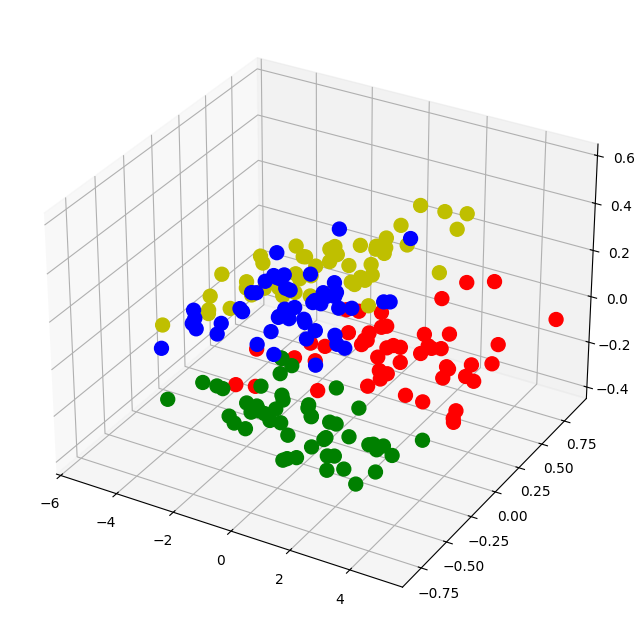

In [23]:
colors_crabs = {'BlueFemale': 'y', 'BlueMale': 'b', 'OrangeFemale': 'r', 'OrangeMale': 'g'}

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(crabs_standarized.PC1,
            crabs_standarized.PC2,
            zs=crabs_standarized.PC3, 
            depthshade=False, 
            c=crabs_data['class'].apply(lambda x: colors_crabs[x]), s=100);

In [25]:
import plotly.express as px
fig = px.scatter_3d(crabs_standarized, x='PC1', y='PC2', z='PC3',
              color='class')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## SECCIÓN 3: Locally Linear Embedding

Este método proyecta los datos en un espacio de menor dimensión tratando de preservar las distancias entre los vecinos.

Entonces, este método se basa en **distancias** locales. Cuando trabajamos con distancias es importante que todas las variables tengan el mismo rango. De lo contrario, una variable con valores grandes podría confundir al modelo.

Para evitar estos problemas usaremos el MinMaxScaler esta vez.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

crabs_min_max = crabs_data.copy()
crabs_min_max[data_columns] = MinMaxScaler().fit_transform(crabs_data[data_columns])
crabs_min_max.describe()

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15)
crabs_lle = lle.fit_transform(crabs_min_max[data_columns])

print('Reconstruction error:', lle.reconstruction_error_)
crabs_min_max[['LLE1','LLE2']]=crabs_lle
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='LLE1', y='LLE2', hue='class', data=crabs_min_max);

In [ ]:
lle = LocallyLinearEmbedding(n_components=3, n_neighbors=15)
crabs_lle = lle.fit_transform(crabs_min_max[data_columns])

print('Reconstruction error:', lle.reconstruction_error_)
crabs_min_max[['LLE1','LLE2', 'LLE3']]=crabs_lle
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(crabs_min_max.LLE1,
            crabs_min_max.LLE2,
            zs=crabs_min_max.LLE3, 
            depthshade=False, 
            c=crabs_data['class'].apply(lambda x: colors_crabs[x]), s=100);

In [ ]:
fig = px.scatter_3d(crabs_min_max, x='LLE1', y='LLE2', z='LLE3',
              color='class')
fig.show()

## SECCIÓN 4: T-Stochastic Neighbor Embedding (TSNE)

TSNE transforma las distancias entre puntos en probabilidades y luego trata de mantener las mismas distribuciones de probabilidad mientras transforma los datos a un espacio dimensional más bajo.

Depende de la inicialización y su resultado puede cambiar entre ejecuciones, también depende **fuertemente** de sus parámetros. Generalmente se usa solo para visualización, no para reducción de dimensionalidad.

Los parámetros más importantes de este modelo son:
* Perplejidad: Equilibra la atención entre los aspectos locales y globales de los datos. Por lo general, estará entre 5 y 50 y tiene un efecto muy fuerte en la visualización final.
* Número de iteraciones.

Podéis consultar esta publicación que cuenta los efectos que tienen los parámetros: https://distill.pub/2016/misread-tsne/

### Usando los datos sin procesar

In [ ]:
from sklearn.manifold import TSNE

crabs_tsne = TSNE(n_components=2, perplexity=10,n_iter=2000, init='random').fit_transform(crabs_data[data_columns])
crabs_data[['TSNE1','TSNE2']]=crabs_tsne

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='class', data=crabs_data)

In [ ]:
crabs_tsne = TSNE(n_components=3, perplexity=10,n_iter=2000, init='random').fit_transform(crabs_data[data_columns])
crabs_data[['TSNE1','TSNE2','TSNE3']]=crabs_tsne
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(crabs_data.TSNE1,
            crabs_data.TSNE2,
            zs=crabs_data.TSNE3, 
            depthshade=False, 
            c=crabs_data['class'].apply(lambda x: colors_crabs[x]), s=100);

### Usando datos escalados

In [ ]:
crabs_tsne = TSNE(n_components=2, perplexity=10,n_iter=1000, init='random').fit_transform(crabs_min_max[data_columns])
crabs_min_max[['TSNE1','TSNE2',]]=crabs_tsne

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='class', data=crabs_min_max);

In [ ]:
crabs_tsne = TSNE(n_components=3, perplexity=10,n_iter=2000, init='random').fit_transform(crabs_min_max[data_columns])
crabs_min_max[['TSNE1','TSNE2','TSNE3']]=crabs_tsne

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(crabs_min_max.TSNE1,
            crabs_min_max.TSNE2,
            zs=crabs_min_max.TSNE3, 
            depthshade=False, 
            c=crabs_min_max['class'].apply(lambda x: colors_crabs[x]), s=100);

### Usando datos estandarizados

In [ ]:
crabs_tsne = TSNE(n_components=2, perplexity=10,n_iter=1000, init='random').fit_transform(crabs_standarized[data_columns])
crabs_standarized[['TSNE1','TSNE2']]=crabs_tsne
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='class', data=crabs_standarized);

In [ ]:
crabs_tsne = TSNE(n_components=3, perplexity=10,n_iter=3000, init='random').fit_transform(crabs_standarized[data_columns])
crabs_standarized[['TSNE1','TSNE2','TSNE3']]=crabs_tsne

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(crabs_standarized.TSNE1,
            crabs_standarized.TSNE2,
            zs=crabs_standarized.TSNE3, 
            depthshade=False, 
            c=crabs_standarized['class'].apply(lambda x: colors_crabs[x]), s=100);

### Inicializando con PCA

In [ ]:
crabs_tsne = TSNE(n_components=2, perplexity=10,n_iter=1000, init='pca').fit_transform(transformed_crabs)
crabs_standarized[['TSNE1','TSNE2',]]=crabs_tsne
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='class', data=crabs_standarized)

In [ ]:
crabs_tsne = TSNE(n_components=3, perplexity=12,n_iter=4000, init='pca').fit_transform(transformed_crabs)
crabs_standarized[['TSNE1','TSNE2','TSNE3']]=crabs_tsne

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(crabs_standarized.TSNE1,
            crabs_standarized.TSNE2,
            zs=crabs_standarized.TSNE3, 
            depthshade=False, 
            c=crabs_standarized['class'].apply(lambda x: colors_crabs[x]), s=100);

In [ ]:
fig = px.scatter_3d(crabs_standarized, x='TSNE1', y='TSNE2', z='TSNE3',
              color='class')
fig.show()

## SECCION 5: Escalado Multidimensional

Este modelo proyecta los datos a un espacio de menos dimensiones intentando preservar las distancias en el espacio original usando una transformación lineal mediante mínimos cuadrados.

El atributo stress_ del modelo indica el MSE del ajuste

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2,n_init=15,metric=True)
crabs_mds = mds.fit_transform(crabs_min_max[data_columns])
crabs_min_max[['MDS1','MDS2']]=crabs_mds
print('MSE:', mds.stress_)
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='MDS1', y='MDS2', hue='class', data=crabs_min_max);

In [ ]:

mds = MDS(n_components=3,n_init=15,metric=True)
crabs_mds = mds.fit_transform(crabs_min_max[data_columns])
crabs_min_max[['MDS1','MDS2','MDS3']]=crabs_mds
print('MSE:', mds.stress_)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(crabs_min_max.MDS2,
            crabs_min_max.MDS1,
            zs=crabs_min_max.MDS3, 
            depthshade=False, 
            c=crabs_min_max['class'].apply(lambda x: colors_crabs[x]), s=100);

## SECCION 6: ISOMAP

Este modelo es una extensión de escalado multidimensional que trata de mantener las distancias geodésicas entre todos los puntos. La distancia geodésica es la distancia más corta entre dos puntos en una superficie. Si la superficie es un plano sería igual a la distancia euclidea.

In [ ]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2,n_neighbors=10)
crabs_isomap = isomap.fit_transform(crabs_min_max[data_columns])
crabs_min_max[['Isomap1','Isomap2']]=crabs_isomap
print('Reconstruction error:', isomap.reconstruction_error())
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='Isomap1', y='Isomap2', hue='class', data=crabs_min_max);

In [ ]:
isomap = Isomap(n_components=3,n_neighbors=10)
crabs_isomap = isomap.fit_transform(crabs_min_max[data_columns])
crabs_min_max[['Isomap1','Isomap2','Isomap3']]=crabs_isomap
print('Reconstruction error:', isomap.reconstruction_error())

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(crabs_min_max.Isomap1,
            crabs_min_max.Isomap2,
            zs=crabs_min_max.Isomap3, 
            depthshade=False, 
            c=crabs_standarized['class'].apply(lambda x: colors_crabs[x]), s=100);

## SECCIÓN 7: Fisher Discriminant Analysis 

Proyecta los datos de manera que se maximice la separabilidad entre clases. **Este modelo es supervisado**.

El espacio que podemos obtener esta limitado al numero de clases -1

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis(n_components=2)
crabs_fda = lda_model.fit_transform(crabs_standarized[data_columns].values,y=crabs_standarized['class'])

crabs_standarized[['FDA1','FDA2']] = crabs_fda

print('Priors:')
pd.DataFrame(lda_model.priors_)
print('Means:')
pd.DataFrame(lda_model.means_)
print('Coefs:')
pd.DataFrame(lda_model.coef_)
print('Explained Variance Ratio')
pd.DataFrame(lda_model.explained_variance_ratio_ )

In [ ]:
lda_model = LinearDiscriminantAnalysis(n_components=3)
crabs_fda = lda_model.fit_transform(crabs_standarized[data_columns].values,y=crabs_standarized['class'])

crabs_standarized[['FDA1','FDA2', 'FDA3']] = crabs_fda

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='FDA1', y='FDA2', hue='class', data=crabs_standarized);

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

plt.scatter(crabs_standarized.FDA1,
            crabs_standarized.FDA2,
            zs=crabs_standarized.FDA3, 
            depthshade=False, 
            c=crabs_standarized['class'].apply(lambda x: colors_crabs[x]), s=100);

In [ ]:
fig = px.scatter_3d(crabs_standarized, x='FDA1', y='FDA2', z='FDA3',
              color='class')
fig.show()

# Sección 8: Datos no tabulares

Los datos tabulares pueden mostrar patrones al reducir su dimensionalidad. Otros tipos de datos como por ejemplo imagenes o texto también se pueden transformar para usarlos mediante métodos de reducción de dimensionalidad convirtiendolos en matrices de valores numéricos


## Imagenes

El conjunto de datos digits corresponden a imagenes de digitos escritos a mano. 

Las imágenes tienen una gran dimensionalidad, por lo que son complicadas de tratar en muchos de los modelos de ML que veremos, una posibilidad es aplicarles métodos de reduccion de dimensionalidad. Habitualmente la dimensionalidad del espacio en el que están la imágenes no se demasiado grande. En este conjunto de imágenes tenemos 64 pixeles.

In [ ]:
from sklearn.datasets import load_digits

In [ ]:
Xd, yd = load_digits(return_X_y=True)

Podemos visualizar las imagenes redimensionandolas a una matriz cuadrada

In [ ]:
plt.figure(figsize=(8,8));
plt.imshow(Xd[0].reshape(8,8), cmap='Greys');

Dado que son imagenes podemos simplemente escalarlas y centrarlas segun el valor mayor de los pixeles

In [ ]:
Xd_s= (Xd-8.0)/16.0

In [ ]:
digits_pca = PCA().fit(Xd_s);

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(digits_pca.explained_variance_ratio_ )+1),digits_pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(digits_pca.explained_variance_ratio_ )+1),
         np.cumsum(digits_pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Se puede ver que los primeros componentes contribuyen proporcionalmente mucho mas que el resto y tenemos bastante parte de la variancia con una fraccion del numero original de dimensiones.

En este caso como son imagenes podemos visualizar el peso que le asigna PCA a los pixeles en cada componente

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12,8));

_ = axes[0,0].imshow(digits_pca.components_[0].reshape(8,8),cmap='Greys'); 
_ = axes[0,1].imshow(digits_pca.components_[1].reshape(8,8),cmap='Greys'); 
_ = axes[0,2].imshow(digits_pca.components_[2].reshape(8,8),cmap='Greys'); 
_ = axes[1,0].imshow(digits_pca.components_[3].reshape(8,8),cmap='Greys'); 
_ = axes[1,1].imshow(digits_pca.components_[4].reshape(8,8),cmap='Greys'); 
_ = axes[1,2].imshow(digits_pca.components_[5].reshape(8,8),cmap='Greys'); 
plt.tight_layout()


Visualizando las dos primeras componentes podemos ver que los digitos estan separados mas o menos por clases solo con esas dos dimensiones.

In [ ]:
X_pca = digits_pca.transform(Xd_s)
data = pd.DataFrame({'PC1':X_pca[:,0], 'PC2':X_pca[:,1],'PC3':X_pca[:,2],'class':yd})
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=data, palette='tab10');

In [ ]:
fig = px.scatter_3d(data, x='PC1', y='PC2', z='PC3',
              color='class')
fig.show()

con t-SNE tenemos una separación casi perfecta

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=10,n_iter=5000, init='pca', n_jobs=-1).fit_transform(Xd_s)
data = pd.DataFrame({'TSNE1':X_tsne[:,0], 'TSNE2':X_tsne[:,1],'class':yd})

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='class', data=data, palette='tab10');

Con LLE tambien hay cierta separacion, pero como en PCA solo con dos dimensiones no es suficiente

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=13)
X_lle = lle.fit_transform(Xd_s)

data = pd.DataFrame({'LLE1':X_lle[:,0], 'LLE2':X_lle[:,1],'class':yd})

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='LLE1', y='LLE2', hue='class', data=data, palette='tab10');

In [ ]:
lle = LocallyLinearEmbedding(n_components=3, n_neighbors=13)
X_lle = lle.fit_transform(Xd_s)

data = pd.DataFrame({'LLE1':X_lle[:,0], 'LLE2':X_lle[:,1],'LLE3':X_lle[:,2],'class':yd})

In [ ]:
fig = px.scatter_3d(data, x='LLE1', y='LLE2', z='LLE3',
              color='class')
fig.show()

## Texto

El conjunto de datos **20 newsgroups** esta formado por textos de grupos de noticias/grupos de discusion de Usenet (un equivalente al actual reddit de la primera epoca de internet). Esta formado por mensajes de 20 categorías diferentes.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Seleccionaremos un subconjunto de 6 categorias para experimentar

In [ ]:
categories = ['alt.atheism', 'comp.graphics', 'sci.space','sci.crypt','rec.sport.baseball','misc.forsale']
Xn, yn = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),categories =categories,return_X_y=True)

In [ ]:
Xn[0]

La transformación de texto a vectores habitualemente se hace haciendo un cálculo sobre las palabras que contienen los textos. Se pueden hacer diferentes preprocesos sobre el texto para limpiarlo y reducir el número de palabras a solo las que aportan significado, en este caso solamente eliminaremos los denominados stop words.

Para hacer el calculo primero usaremos cierta cantidad de las palabras mas frecuentes como atributos y usaremos como valores su frecuencia en los documentos.

Existen multiples maneras de normalizar estos vectores, podemos escalarlos, estandarizarlos, convertirlos en vectores de norma unitaria, ... Cada transformación nos dara probalemente resultados diferentes, sera un hiperparametro mas a explorar si lo usamos para obtener el conjunto de datos

Convertiremos los vectores de palabras a vectores de norma unitaria por ejemplo. Esto lo que hace es proyectarlos sobre una hiperesfera de radio 1. Podemos probar con otras normalizaciones y obtendremos resultados diferentes.

In [ ]:
from sklearn.preprocessing import Normalizer

In [ ]:
Xn_v = CountVectorizer(max_features=500, stop_words="english").fit_transform(Xn)
Xn_s = Normalizer().fit_transform(np.asarray(Xn_v.todense()))

In [ ]:
news_pca = PCA().fit(Xn_s);

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(news_pca.explained_variance_ratio_ )+1),news_pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(news_pca.explained_variance_ratio_ )+1),
         np.cumsum(news_pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Podemos ver que la variancia se distribuye entre todos los atributos

In [ ]:
X_pca = news_pca.transform(Xn_s)
data = pd.DataFrame({'PC1':X_pca[:,0], 'PC2':X_pca[:,1],'class':yn})
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=data, palette='tab10');

Aun asi tenemos cierta separabilidad entre las diferentes clases proyectando por los dos primeros componentes.

El t-SNE nos puede dar resultados muy diferentes dependiendo de la inicializacion y los parametros que usemos

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=30, early_exaggeration=15, n_iter=1000, metric='cosine', init='pca', n_jobs=-1).fit_transform(Xn_s)
data = pd.DataFrame({'TSNE1':X_tsne[:,0], 'TSNE2':X_tsne[:,1],'class':yn})

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='class', data=data, palette='tab10');

Nos pasara algo parecido con LLE dependiendo del numero de vecinos que empleemos.

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=55)
X_lle = lle.fit_transform(Xn_s)

data = pd.DataFrame({'LLE1':X_lle[:,0], 'LLE2':X_lle[:,1],'class':yn})

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='LLE1', y='LLE2', hue='class', data=data, palette='tab10');

Otra opcion para obtener valores para los atributos es tener en cuenta la frecuencia de las palabras, pero relativa al numero de veces que aparecen en el conjunto de documentos. TF = term frequency, IDF=Inverse document frequency 

In [ ]:
Xn_v = TfidfVectorizer(max_features=500, stop_words="english").fit_transform(Xn)
Xn_s = Normalizer().fit_transform(np.asarray(Xn_v.todense()))

In [ ]:
news_pca = PCA().fit(Xn_s);

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(news_pca.explained_variance_ratio_ )+1),news_pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(news_pca.explained_variance_ratio_ )+1),
         np.cumsum(news_pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

In [ ]:
X_pca = news_pca.transform(Xn_s)
data = pd.DataFrame({'PC1':X_pca[:,0], 'PC2':X_pca[:,1],'class':yn})
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=data, palette='tab10');

In [ ]:
X_tsne = TSNE(n_components=2, perplexity=30, early_exaggeration=15, n_iter=1000, metric='cosine', init='pca', n_jobs=-1).fit_transform(Xn_s)
data = pd.DataFrame({'TSNE1':X_tsne[:,0], 'TSNE2':X_tsne[:,1],'class':yn})

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='class', data=data, palette='tab10');

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=17)
X_lle = lle.fit_transform(Xn_s)

data = pd.DataFrame({'LLE1':X_lle[:,0], 'LLE2':X_lle[:,1],'class':yn})

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x='LLE1', y='LLE2', hue='class', data=data, palette='tab10');

In [ ]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")